<a href="https://colab.research.google.com/github/GuoyaoShen/DiatomDL/blob/main/main_inverse_v_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script works on the inverse problem.

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

In [3]:
path_dataset = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/diatom_219.npz'

data = np.load(path_dataset)
print(data['param'].shape)
print(data['R'].shape)
print(data['T'].shape)

(219, 11)
(219, 1001, 2)
(219, 1001, 2)


In [4]:
param = data['param']
spectra_R = data['R'][...,1]
spectra_T = data['T'][...,1]

print(param.shape)
print(spectra_R.shape)
print(spectra_T.shape)
# print(spectra_R)

(219, 11)
(219, 1001)
(219, 1001)


## Create Dataset

In [5]:
# inverse problem: spectra -> param
tensor_x = torch.Tensor(spectra_R) # transform to torch tensor
tensor_y = torch.Tensor(param)

print(tensor_x.shape)
print(tensor_y.shape)

dataset_ref = TensorDataset(tensor_x,tensor_y)

dataset_ref_train, dataset_ref_test = random_split(dataset_ref, [200, 19], generator=torch.Generator().manual_seed(7))
print(len(dataset_ref_train))
print(len(dataset_ref_test))

dataloader_ref_train = DataLoader(dataset_ref_train, batch_size=10, shuffle=True)
dataloader_ref_test = DataLoader(dataset_ref_test, batch_size=10, shuffle=True)
print(len(dataloader_ref_train))
print(len(dataloader_ref_test))

torch.Size([219, 1001])
torch.Size([219, 11])
200
19
20
2


# Model

## Model Construct

In [158]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class SquareLayer(nn.Module):
    '''
    This layer works as a function of: y = xAx+(Bx)+C
    '''
    def __init__(self, dim_in, dim_out):
        super(SquareLayer, self).__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)
        self.bilinear = nn.Bilinear(dim_in, dim_in, dim_out)

    def forward(self, x):
        out = self.linear(x) + self.bilinear(x,x)
        return  out


class NetDense(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NetDense, self).__init__()
        self.ksz1d = 50

        self.fc_encoder = nn.Sequential(
        # nn.Linear(dim_in, 2000),
        # nn.ReLU(True),
        # nn.Linear(2000, 3000),
        # nn.ReLU(True),
        # nn.Linear(3000, 4000),
        # nn.ReLU(True),
        # nn.Linear(4000, 2000),
        # nn.ReLU(True),
        # nn.Linear(2000, 500),
        # nn.ReLU(True),
        # # nn.Linear(1000, 500),
        # # nn.ReLU(True),
        # # nn.Linear(500, 50),
        # # nn.ReLU(True),
        # nn.Linear(500, dim_out),
        # # nn.ReLU(True),


        nn.Linear(dim_in, 2000),
        nn.ReLU(True),
        nn.Linear(2000, 3000),
        nn.ReLU(True),
        nn.Linear(3000, 1500),
        nn.ReLU(True),
        nn.Linear(1500, 500),
        nn.ReLU(True),
        nn.Linear(500, 100),
        nn.ReLU(True),
        # nn.Linear(1000, 500),
        # nn.ReLU(True),
        # nn.Linear(500, 50),
        # nn.ReLU(True),
        nn.Linear(100, dim_out),
        # nn.ReLU(True),
        )

        self.conv = nn.Conv1d(1, 1, kernel_size=self.ksz1d, stride=1)

    def forward(self, x):
        out = self.fc_encoder(x)

        return out

## Train & Test Function

In [110]:
def train_model(train_dataloader, test_dataloader, optimizer, loss, net, device, NUM_EPOCH=5, scheduler=None, use_logger=False):
    net = net.to(device)
    net.train()

    if scheduler != None:
        print('*** WILL USE SCHEDULER ***')

    for i in range(NUM_EPOCH):
        running_loss = 0.0
        # running_acc = 0.0
        for idx, data in enumerate(train_dataloader):
            X, y = data
            # print(X.shape)
            # print(y.shape)

            X = X.to(device)
            y = y.to(device)

            # if idx==0:
            #     print(X.shape, y.shape)

            y_pred = net(X)

            optimizer.zero_grad()
            loss_train = loss(y_pred, y)
            loss_train.backward()
            optimizer.step()
            running_loss += loss_train.item()

            # if (idx+1)%5==0:
            #     print('EPOCH '+str(i+1)+'/'+str(NUM_EPOCH)+' || '+'STEP '+str(idx+1)+'/'+str(len(train_dataloader))+' || '+'LOSS: '+str(running_loss/(idx+1)))
            #     print('===================================================')
        print('----------------------------------------------------------------------')
        print('*** EPOCH '+str(i+1)+' || AVG LOSS '+str(running_loss/len(train_dataloader)))
        # print('----------------------------------------------------------------------')

        # test model for each epoch
        test_model(test_dataloader, loss, net, device, i, use_logger)

        # Tensorboard Logger
        if use_logger:
            logger.add_scalar(DATA_NAME_LOSS_TRAIN, running_loss/len(train_dataloader), (i+1))
            

In [111]:
def test_model(test_dataloader, loss, net, device, idx_epoch, use_logger_test=False):
    net = net.to(device)
    net.eval()

    running_loss = 0.0
    for idx, data in enumerate(test_dataloader):
        X, y = data

        X = X.to(device)
        y = y.to(device)

        y_pred = net(X)

        loss_train = loss(y_pred, y)
        running_loss += loss_train.item()

    # print('----------------------------------------------------------------------')
    print('### TEST LOSS ', str(running_loss/len(test_dataloader)))
    # print('### TEST LOSS ', str(running_loss/(idx+1)))
    # print('----------------------------------------------------------------------')

    # Tensorboard Logger
    if use_logger_test:
        logger.add_scalar(DATA_NAME_LOSS_TEST, running_loss/len(test_dataloader), (idx_epoch+1))

# Load Tensorboard

In [46]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [47]:
ROOT_LOG_DIR = '/content/drive/My Drive/BU Class/Research/BioDL_Project/logs'

In [48]:
import torch
import os
from torch.utils.tensorboard import SummaryWriter
LOG_DIR = "densenet6_inverse_R" # Sub-Directory for storing this specific experiment's logs
logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, LOG_DIR))
DATA_NAME_LOSS_TRAIN = "LOSS_TRAIN"
DATA_NAME_LOSS_TEST = "LOSS_TEST"

In [ ]:
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

# Train & Test

In [160]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
learning_rate = 1e-4

# torch.manual_seed(123)

net_dense = NetDense(1001,11)

optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adadelta(net_dense.parameters(), lr=learning_rate)
criteon = nn.MSELoss()
scheduler = None


train_model(dataloader_ref_train, dataloader_ref_test, optimizer, criteon, net_dense, device, NUM_EPOCH=3000, scheduler=scheduler, use_logger=False)

流式输出内容被截断，只能显示最后 5000 行内容。
### TEST LOSS  1.884181483546854e-05
----------------------------------------------------------------------
*** EPOCH 1335 || AVG LOSS 2.265365615130577e-05
### TEST LOSS  2.023991373789613e-05
----------------------------------------------------------------------
*** EPOCH 1336 || AVG LOSS 2.3214740758703555e-05
### TEST LOSS  2.7860418413183652e-05
----------------------------------------------------------------------
*** EPOCH 1337 || AVG LOSS 2.4415559300905444e-05
### TEST LOSS  1.65406490850728e-05
----------------------------------------------------------------------
*** EPOCH 1338 || AVG LOSS 2.7460504088594462e-05
### TEST LOSS  2.2880670258018654e-05
----------------------------------------------------------------------
*** EPOCH 1339 || AVG LOSS 3.30771789776918e-05
### TEST LOSS  4.564874689094722e-05
----------------------------------------------------------------------
*** EPOCH 1340 || AVG LOSS 3.444695867074188e-05
### TEST LOSS  2.43639724430

## Save Model

In [161]:
# save model
PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densenet6_inverse_R.pt'
torch.save(net_dense.state_dict(), PATH_MODEL)

print('MODEL SAVED')

MODEL SAVED


# Load Model (Optional)

In [164]:
PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densenet6_inverse_R.pt'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_dense = NetDense(1001,11)
net_dense.load_state_dict(torch.load(PATH_MODEL))
net_dense = net_dense.to(device)
net_dense.eval()

print('MODEL LOADED')
print(device)

MODEL LOADED
cuda:0


## Visualize Loaded Model

torch.Size([219, 1001])
torch.Size([219, 11])
torch.Size([9, 1001])
torch.Size([9, 11])
(9, 11)
(9, 11)


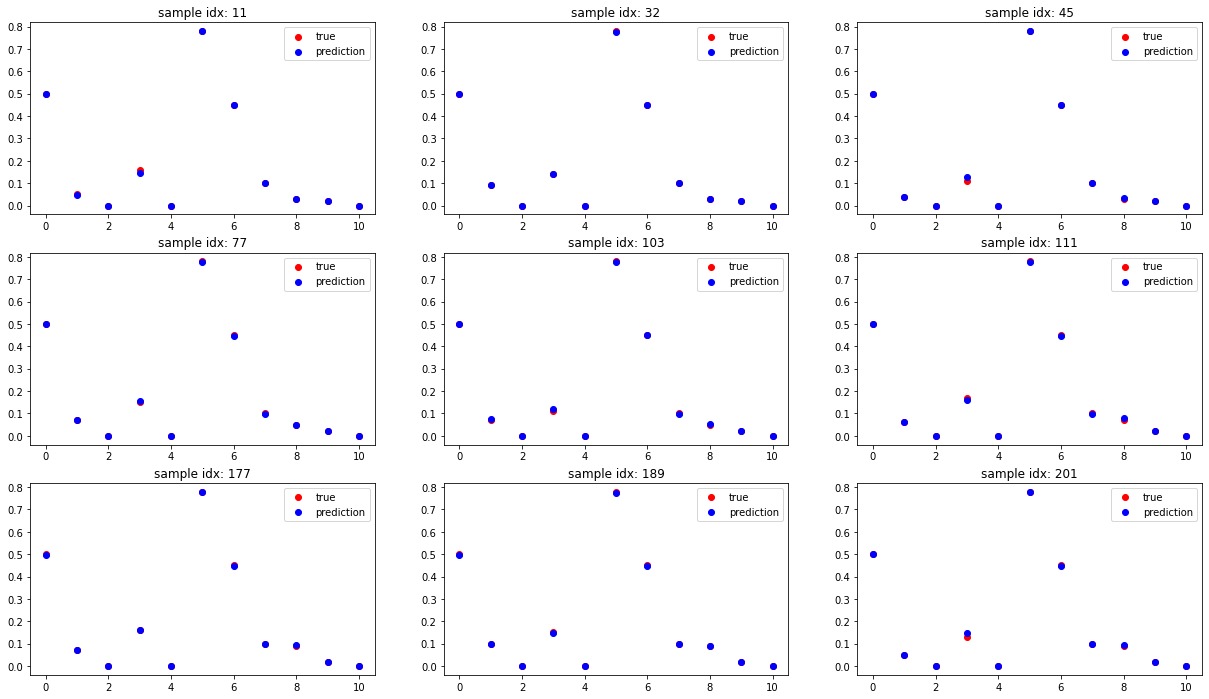

In [165]:
idx_test = [11,32,45,77,103,111,177,189,201]
print(tensor_x.shape)
print(tensor_y.shape)

X_test = tensor_x[idx_test,:]
y_test = tensor_y[idx_test,:]
print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print(y_test_np.shape)
print(y_test_pred_np.shape)


plt.figure(1, figsize=(21,12))
for idx_fig in range(9):
    plt.subplot(3, 3, idx_fig+1)
    plt.scatter(np.arange(11), y_test_np[idx_fig,...], c='r')
    plt.scatter(np.arange(11), y_test_pred_np[idx_fig,...], c='b')
    plt.legend(('true', 'prediction'))
    plt.title('sample idx: '+str(idx_test[idx_fig]))

# Visualize Results

torch.Size([219, 1001])
torch.Size([219, 11])
torch.Size([1, 1001])
torch.Size([1, 11])
TRUE [[0.5    0.1    0.     0.14   0.     0.7794 0.45   0.1    0.03   0.02
  0.    ]]
PRED [[ 5.0010878e-01  9.9314779e-02 -5.8420002e-05  1.4148822e-01
  -4.3771788e-04  7.7960539e-01  4.4934222e-01  9.9564917e-02
   3.2182097e-02  1.9894011e-02  1.2491457e-04]]


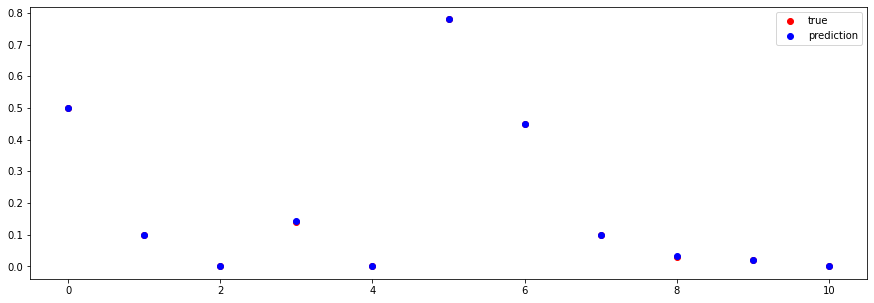

In [162]:
idx_test = 33
print(tensor_x.shape)
print(tensor_y.shape)

X_test = tensor_x[idx_test,:].unsqueeze(0)
y_test = tensor_y[idx_test,:].unsqueeze(0)

print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print('TRUE', y_test_np)
print('PRED', y_test_pred_np)

# plt.figure(1)
# plt.plot(np.arange(1001), y_test_np)
# plt.figure(2)
# plt.plot(np.arange(1001), y_test_pred_np)

plt.figure(3, figsize=(15,5))
plt.scatter(np.arange(11), y_test_np, c='r')
plt.scatter(np.arange(11), y_test_pred_np, c='b')
plt.legend(('true', 'prediction'))

torch.Size([219, 1001])
torch.Size([219, 11])
torch.Size([1, 1001])
torch.Size([1, 11])
TRUE [[0.5    0.08   0.     0.16   0.     0.7794 0.45   0.1    0.07   0.02
  0.    ]]
PRED [[ 4.9738267e-01  7.8955978e-02 -2.3203343e-04  1.6564873e-01
   1.3675541e-05  7.7424455e-01  4.4669682e-01  9.9301644e-02
   7.0971102e-02  1.9596621e-02  2.3116358e-04]]


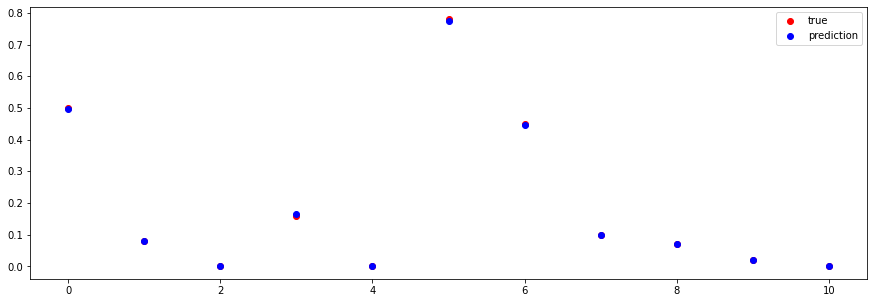

In [163]:
idx_test = 123
print(tensor_x.shape)
print(tensor_y.shape)

X_test = tensor_x[idx_test,:].unsqueeze(0)
y_test = tensor_y[idx_test,:].unsqueeze(0)

print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print('TRUE', y_test_np)
print('PRED', y_test_pred_np)

# plt.figure(1)
# plt.plot(np.arange(1001), y_test_np)
# plt.figure(2)
# plt.plot(np.arange(1001), y_test_pred_np)

plt.figure(3, figsize=(15,5))
plt.scatter(np.arange(11), y_test_np, c='r')
plt.scatter(np.arange(11), y_test_pred_np, c='b')
plt.legend(('true', 'prediction'))